# Phase 3.2: Counterfactual Explanation Generation
## Task: Generate counterfactuals to switch class predictions with realistic operational bounds

In [1]:
# Install required packages for counterfactual generation
%pip install dice-ml --quiet
%pip install tensorflow --quiet
%pip install scikit-learn --quiet
%pip install pandas numpy matplotlib --quiet

# Alternative installation if dice-ml fails
# %pip install git+https://github.com/interpretml/DiCE.git --quiet

print("✅ Installation complete. Please restart kernel if needed.")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✅ Installation complete. Please restart kernel if needed.


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Try to import dice_ml with error handling
try:
    import dice_ml
    from dice_ml import Dice
    print("✅ DiCE ML imported successfully")
    DICE_AVAILABLE = True
except ImportError as e:
    print(f"⚠️ DiCE ML not available: {e}")
    print("Will use alternative counterfactual generation method")
    DICE_AVAILABLE = False

print("✅ Core libraries imported successfully")

✅ DiCE ML imported successfully
✅ Core libraries imported successfully


In [2]:
# Load the prepared dataset from Phase 1
print("📊 Loading dataset from Phase 1...")

load_df = pd.read_excel("load_scenarios.xlsx")
cont_df = pd.read_csv("n1_contingency_balanced_filled_complete.csv")
cont_df = cont_df[cont_df['Scenario'] < 1000].reset_index(drop=True)

# Extract features
load_features = load_df[["P_mw", "Q_mvar"]].values
load_features = load_features.reshape(1000, 40)
load_features_expanded = np.repeat(load_features, 41, axis=0)

bus_cols = [col for col in cont_df.columns if col.startswith("V_bus_")]
line_cols = [col for col in cont_df.columns if col.startswith("Loading_line_")]
voltages = cont_df[bus_cols].values.astype(np.float32)
line_flows = cont_df[line_cols].values.astype(np.float32)

# Combine features
X = np.concatenate([load_features_expanded, voltages, line_flows], axis=1)
y = cont_df['Severity'].values.astype(np.int64)

# Create feature names
feature_names = []
for i in range(20):
    feature_names.extend([f"P_load_{i}", f"Q_load_{i}"])
feature_names.extend([f"V_bus_{i}" for i in range(len(bus_cols))])
feature_names.extend([f"Loading_line_{i}" for i in range(len(line_cols))])

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Class distribution: {np.bincount(y)}")

📊 Loading dataset from Phase 1...
Dataset shape: (41000, 111)
Number of features: 111
Class distribution: [23395 17605]
Dataset shape: (41000, 111)
Number of features: 111
Class distribution: [23395 17605]


In [3]:
# Prepare data for DiCE (requires pandas DataFrame)
print("🔧 Preparing data for counterfactual generation...")

# Create DataFrame with feature names
df = pd.DataFrame(X, columns=feature_names)
df['severity'] = y

# Split into train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

# Define continuous and categorical features
continuous_features = feature_names  # All our features are continuous
categorical_features = []

# Define operational bounds for power system features
bounds = {
    # Load bounds (±20% variation from original)
    **{f"P_load_{i}": (0.1, 2.0) for i in range(20)},
    **{f"Q_load_{i}": (0.05, 1.5) for i in range(20)},
    # Voltage bounds (0.95 to 1.05 p.u. - typical operating range)
    **{f"V_bus_{i}": (0.95, 1.05) for i in range(len(bus_cols))},
    # Line loading bounds (0% to 100%)
    **{f"Loading_line_{i}": (0.0, 100.0) for i in range(len(line_cols))}
}

print("✅ Data preparation complete")

🔧 Preparing data for counterfactual generation...
Training set size: 32800
Test set size: 8200
✅ Data preparation complete


In [4]:
# Create a simple model wrapper for DiCE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

print("🤖 Training surrogate model for counterfactual generation...")

# Prepare features and target
X_train = train_df.drop('severity', axis=1)
y_train = train_df['severity']
X_test = test_df.drop('severity', axis=1)
y_test = test_df['severity']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model (works well with DiCE)
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
model.fit(X_train_scaled, y_train)

# Evaluate model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Surrogate model accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

🤖 Training surrogate model for counterfactual generation...
Surrogate model accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4679
           1       1.00      1.00      1.00      3521

    accuracy                           1.00      8200
   macro avg       1.00      1.00      1.00      8200
weighted avg       1.00      1.00      1.00      8200

Surrogate model accuracy: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4679
           1       1.00      1.00      1.00      3521

    accuracy                           1.00      8200
   macro avg       1.00      1.00      1.00      8200
weighted avg       1.00      1.00      1.00      8200



In [5]:
# Create model wrapper and counterfactual generator
if DICE_AVAILABLE:
    # Use DiCE if available
    class SklearnModelWrapper:
        def __init__(self, model, scaler):
            self.model = model
            self.scaler = scaler
        
        def predict(self, X):
            if isinstance(X, pd.DataFrame):
                X = X.values
            X_scaled = self.scaler.transform(X)
            return self.model.predict(X_scaled)
        
        def predict_proba(self, X):
            if isinstance(X, pd.DataFrame):
                X = X.values
            X_scaled = self.scaler.transform(X)
            return self.model.predict_proba(X_scaled)

    model_wrapper = SklearnModelWrapper(model, scaler)

    # Create DiCE data object
    dice_data = dice_ml.Data(
        dataframe=train_df,
        continuous_features=continuous_features,
        outcome_name='severity'
    )

    # Create DiCE model object
    dice_model = dice_ml.Model(
        model=model_wrapper,
        backend='sklearn'
    )

    # Create DiCE explainer
    explainer = Dice(dice_data, dice_model, method='random')
    print("✅ DiCE explainer created successfully")
    
else:
    # Enhanced counterfactual generation with multiple strategies
    from scipy.optimize import minimize
    
    class EnhancedCounterfactualGenerator:
        def __init__(self, model, scaler, feature_names, bounds):
            self.model = model
            self.scaler = scaler
            self.feature_names = feature_names
            self.bounds = bounds
            
        def generate_counterfactuals(self, query_instance, total_CFs=10, desired_class=1, 
                                   features_to_vary='all', max_attempts=50):
            """Enhanced counterfactual generation with multiple strategies"""
            query_scaled = self.scaler.transform(query_instance.values)
            original_pred = self.model.predict_proba(query_scaled)[0]
            original_class = np.argmax(original_pred)
            
            print(f"Original prediction: {original_pred}, class: {original_class}")
            
            counterfactuals = []
            attempts = 0
            
            while len(counterfactuals) < total_CFs and attempts < max_attempts:
                attempts += 1
                
                # Strategy 1: Random perturbation with varying magnitudes
                success = self._try_random_perturbation(query_instance, desired_class, counterfactuals)
                if success:
                    continue
                    
                # Strategy 2: Targeted feature modification
                success = self._try_targeted_modification(query_instance, desired_class, counterfactuals)
                if success:
                    continue
                    
                # Strategy 3: Optimization-based approach with multiple starting points
                success = self._try_optimization_approach(query_instance, desired_class, counterfactuals)
                if success:
                    continue
                    
                # Strategy 4: Gradient-based perturbation
                success = self._try_gradient_based(query_instance, desired_class, counterfactuals)
                
            print(f"Generated {len(counterfactuals)} counterfactuals in {attempts} attempts")
            
            # Return mock DiCE-like object
            class MockCFExamples:
                def __init__(self, cfs):
                    self.cf_examples_list = [pd.concat(cfs, ignore_index=True) if cfs else None]
            
            return MockCFExamples(counterfactuals)
        
        def _try_random_perturbation(self, query_instance, desired_class, counterfactuals):
            """Try random perturbation with varying noise levels"""
            for noise_scale in [0.05, 0.1, 0.2, 0.3]:
                perturbed = query_instance.values[0].copy()
                
                # Select random subset of features to modify
                n_features_to_change = np.random.randint(5, min(20, len(self.feature_names)))
                features_to_change = np.random.choice(len(self.feature_names), 
                                                    n_features_to_change, replace=False)
                
                for j in features_to_change:
                    feature = self.feature_names[j]
                    if feature in self.bounds:
                        min_val, max_val = self.bounds[feature]
                        current_val = perturbed[j]
                        
                        # Use different noise distributions
                        if np.random.random() < 0.5:
                            noise = np.random.normal(0, noise_scale) * current_val
                        else:
                            noise = np.random.uniform(-noise_scale, noise_scale) * current_val
                        
                        perturbed[j] = np.clip(current_val + noise, min_val, max_val)
                
                if self._check_and_add_counterfactual(perturbed, desired_class, counterfactuals):
                    return True
            return False
        
        def _try_targeted_modification(self, query_instance, desired_class, counterfactuals):
            """Modify specific feature types that are most likely to change class"""
            perturbed = query_instance.values[0].copy()
            
            # Focus on different feature types
            feature_groups = {
                'load': [i for i, name in enumerate(self.feature_names) if 'load' in name],
                'voltage': [i for i, name in enumerate(self.feature_names) if 'V_bus' in name],
                'flow': [i for i, name in enumerate(self.feature_names) if 'Loading' in name]
            }
            
            # Try modifying each group
            for group_name, indices in feature_groups.items():
                if not indices:
                    continue
                    
                # Select subset of features from this group
                n_to_modify = min(np.random.randint(2, 8), len(indices))
                selected_indices = np.random.choice(indices, n_to_modify, replace=False)
                
                for j in selected_indices:
                    feature = self.feature_names[j]
                    if feature in self.bounds:
                        min_val, max_val = self.bounds[feature]
                        current_val = perturbed[j]
                        
                        # Apply group-specific modifications
                        if group_name == 'load':
                            # For loads, try both increase and decrease
                            factor = np.random.choice([0.7, 0.8, 1.2, 1.3, 1.5])
                            new_val = current_val * factor
                        elif group_name == 'voltage':
                            # For voltages, small changes can have big impact
                            change = np.random.uniform(-0.03, 0.03)
                            new_val = current_val + change
                        else:  # flow
                            # For line flows, try reducing or increasing loading
                            factor = np.random.choice([0.5, 0.6, 1.4, 1.6, 1.8])
                            new_val = current_val * factor
                        
                        perturbed[j] = np.clip(new_val, min_val, max_val)
                
                if self._check_and_add_counterfactual(perturbed, desired_class, counterfactuals):
                    return True
            
            return False
        
        def _try_optimization_approach(self, query_instance, desired_class, counterfactuals):
            """Enhanced optimization with multiple starting points"""
            for attempt in range(3):  # Multiple starting points
                # Create different starting points
                if attempt == 0:
                    start_point = query_instance.values[0].copy()
                else:
                    start_point = query_instance.values[0].copy()
                    # Add small random perturbation to starting point
                    for j in range(len(start_point)):
                        if self.feature_names[j] in self.bounds:
                            min_val, max_val = self.bounds[self.feature_names[j]]
                            noise = np.random.normal(0, 0.05) * start_point[j]
                            start_point[j] = np.clip(start_point[j] + noise, min_val, max_val)
                
                def objective(x):
                    try:
                        x_scaled = self.scaler.transform(x.reshape(1, -1))
                        pred_proba = self.model.predict_proba(x_scaled)[0]
                        
                        # Weighted objective: maximize target class prob + minimize distance
                        target_prob = pred_proba[desired_class]
                        distance_penalty = np.linalg.norm(x - query_instance.values[0]) * 0.01
                        
                        return -(target_prob - distance_penalty)
                    except:
                        return 1000  # Large penalty for invalid inputs
                
                # Set bounds for optimization
                opt_bounds = []
                for j, feature in enumerate(self.feature_names):
                    if feature in self.bounds:
                        opt_bounds.append(self.bounds[feature])
                    else:
                        # Use data-driven bounds if no explicit bounds
                        min_val = start_point[j] * 0.5
                        max_val = start_point[j] * 1.5
                        opt_bounds.append((min_val, max_val))
                
                try:
                    # Try different optimization methods
                    methods = ['L-BFGS-B', 'SLSQP']
                    for method in methods:
                        result = minimize(
                            objective,
                            start_point,
                            method=method,
                            bounds=opt_bounds,
                            options={'maxiter': 200, 'ftol': 1e-6}
                        )
                        
                        if result.success:
                            if self._check_and_add_counterfactual(result.x, desired_class, counterfactuals):
                                return True
                except:
                    continue
            
            return False
        
        def _try_gradient_based(self, query_instance, desired_class, counterfactuals):
            """Gradient-based perturbation using feature importance"""
            try:
                # Get feature importances if available
                if hasattr(self.model, 'feature_importances_'):
                    importances = self.model.feature_importances_
                else:
                    # Use random weights as fallback
                    importances = np.random.random(len(self.feature_names))
                
                perturbed = query_instance.values[0].copy()
                
                # Select features based on importance
                top_features = np.argsort(importances)[-20:]  # Top 20 important features
                
                for j in top_features:
                    feature = self.feature_names[j]
                    if feature in self.bounds:
                        min_val, max_val = self.bounds[feature]
                        current_val = perturbed[j]
                        importance = importances[j]
                        
                        # Scale change by importance
                        change_magnitude = importance * np.random.uniform(0.1, 0.4)
                        direction = np.random.choice([-1, 1])
                        
                        new_val = current_val + direction * change_magnitude * current_val
                        perturbed[j] = np.clip(new_val, min_val, max_val)
                
                return self._check_and_add_counterfactual(perturbed, desired_class, counterfactuals)
            except:
                return False
        
        def _check_and_add_counterfactual(self, perturbed, desired_class, counterfactuals):
            """Check if perturbed instance achieves desired class and add to list"""
            try:
                perturbed_scaled = self.scaler.transform(perturbed.reshape(1, -1))
                new_pred = self.model.predict_proba(perturbed_scaled)[0]
                predicted_class = np.argmax(new_pred)
                
                if predicted_class == desired_class:
                    # Additional check: ensure confidence is reasonable
                    if new_pred[desired_class] > 0.6:  # At least 60% confidence
                        cf_df = pd.DataFrame(perturbed.reshape(1, -1), columns=self.feature_names)
                        counterfactuals.append(cf_df)
                        return True
            except:
                pass
            return False

    explainer = EnhancedCounterfactualGenerator(model, scaler, feature_names, bounds)
    print("✅ Enhanced counterfactual generator created successfully")

✅ DiCE explainer created successfully


In [6]:
# Generate counterfactuals for selected test instances with enhanced method
print("🔄 Generating counterfactuals with enhanced method...")

# Increase the number of instances and counterfactuals per instance
stable_instances = test_df[test_df['severity'] == 0].head(10)  # Increased from 5
unstable_instances = test_df[test_df['severity'] == 1].head(10)  # Increased from 5

all_counterfactuals = []
all_original_instances = []

# Enhanced function to extract counterfactuals properly
def extract_counterfactuals(cf_examples):
    """Extract counterfactual DataFrame from output"""
    try:
        if hasattr(cf_examples, 'cf_examples_list') and len(cf_examples.cf_examples_list) > 0:
            cf_data = cf_examples.cf_examples_list[0]
            if cf_data is not None:
                if hasattr(cf_data, 'final_cfs_df'):
                    return cf_data.final_cfs_df
                elif isinstance(cf_data, pd.DataFrame):
                    return cf_data
    except:
        pass
    return None

# Generate counterfactuals for stable instances (try to make them unstable)
print("Generating counterfactuals for stable instances...")
for idx, (_, instance) in enumerate(stable_instances.iterrows()):
    try:
        query_instance = instance.drop('severity').to_frame().T
        
        # Increase number of counterfactuals requested
        if DICE_AVAILABLE:
            cf_examples = explainer.generate_counterfactuals(
                query_instance,
                total_CFs=8,  # Increased from 3
                desired_class=1,
                features_to_vary='all'
            )
        else:
            cf_examples = explainer.generate_counterfactuals(
                query_instance,
                total_CFs=8,  # Increased from 3
                desired_class=1,
                max_attempts=100  # Increased attempts
            )
        
        # Extract counterfactual DataFrame
        cf_df = extract_counterfactuals(cf_examples)
        
        if cf_df is not None and len(cf_df) > 0:
            cf_df = cf_df.copy()
            # Add metadata columns
            cf_df['original_class'] = 0
            cf_df['target_class'] = 1
            cf_df['instance_id'] = f"stable_{idx}"
            all_counterfactuals.append(cf_df)
            
            # Store original instance
            orig_df = query_instance.copy()
            orig_df['severity'] = 0
            orig_df['original_class'] = 0
            orig_df['target_class'] = 1
            orig_df['instance_id'] = f"stable_{idx}"
            all_original_instances.append(orig_df)
            print(f"✅ Generated {len(cf_df)} counterfactuals for stable instance {idx}")
        else:
            print(f"⚠️ No counterfactuals generated for stable instance {idx}")
            
    except Exception as e:
        print(f"Failed to generate counterfactual for stable instance {idx}: {e}")

# Generate counterfactuals for unstable instances (try to make them stable)
print("Generating counterfactuals for unstable instances...")
for idx, (_, instance) in enumerate(unstable_instances.iterrows()):
    try:
        query_instance = instance.drop('severity').to_frame().T
        
        # Generate counterfactuals
        if DICE_AVAILABLE:
            cf_examples = explainer.generate_counterfactuals(
                query_instance,
                total_CFs=8,  # Increased from 3
                desired_class=0,
                features_to_vary='all'
            )
        else:
            cf_examples = explainer.generate_counterfactuals(
                query_instance,
                total_CFs=8,  # Increased from 3
                desired_class=0,
                max_attempts=100  # Increased attempts
            )
        
        # Extract counterfactual DataFrame
        cf_df = extract_counterfactuals(cf_examples)
        
        if cf_df is not None and len(cf_df) > 0:
            cf_df = cf_df.copy()
            # Add metadata columns
            cf_df['original_class'] = 1
            cf_df['target_class'] = 0
            cf_df['instance_id'] = f"unstable_{idx}"
            all_counterfactuals.append(cf_df)
            
            # Store original instance
            orig_df = query_instance.copy()
            orig_df['severity'] = 1
            orig_df['original_class'] = 1
            orig_df['target_class'] = 0
            orig_df['instance_id'] = f"unstable_{idx}"
            all_original_instances.append(orig_df)
            print(f"✅ Generated {len(cf_df)} counterfactuals for unstable instance {idx}")
        else:
            print(f"⚠️ No counterfactuals generated for unstable instance {idx}")
            
    except Exception as e:
        print(f"Failed to generate counterfactual for unstable instance {idx}: {e}")

print(f"\n✅ Generated counterfactuals for {len(all_counterfactuals)} instances")
if len(all_counterfactuals) > 0:
    total_cfs = sum(len(cf) for cf in all_counterfactuals)
    print(f"📊 Total individual counterfactuals: {total_cfs}")
    avg_cfs_per_instance = total_cfs / len(all_counterfactuals) if len(all_counterfactuals) > 0 else 0
    print(f"📊 Average counterfactuals per instance: {avg_cfs_per_instance:.2f}")
else:
    print("⚠️ No counterfactuals were successfully generated")

🔄 Generating counterfactuals with enhanced method...
Generating counterfactuals for stable instances...


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


✅ Generated 8 counterfactuals for stable instance 0


100%|██████████| 1/1 [00:04<00:00,  4.00s/it]



✅ Generated 8 counterfactuals for stable instance 1


100%|██████████| 1/1 [00:05<00:00,  5.44s/it]


✅ Generated 8 counterfactuals for stable instance 2


100%|██████████| 1/1 [00:03<00:00,  3.41s/it]



✅ Generated 8 counterfactuals for stable instance 3


100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


✅ Generated 8 counterfactuals for stable instance 4


100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


✅ Generated 8 counterfactuals for stable instance 5


100%|██████████| 1/1 [01:53<00:00, 113.82s/it]


✅ Generated 8 counterfactuals for stable instance 6


100%|██████████| 1/1 [00:03<00:00,  3.40s/it]


✅ Generated 8 counterfactuals for stable instance 7


100%|██████████| 1/1 [00:03<00:00,  3.32s/it]



✅ Generated 8 counterfactuals for stable instance 8


100%|██████████| 1/1 [00:03<00:00,  3.48s/it]



✅ Generated 8 counterfactuals for stable instance 9
Generating counterfactuals for unstable instances...


100%|██████████| 1/1 [00:03<00:00,  3.38s/it]



✅ Generated 8 counterfactuals for unstable instance 0


100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


✅ Generated 8 counterfactuals for unstable instance 1


100%|██████████| 1/1 [00:05<00:00,  5.34s/it]



✅ Generated 8 counterfactuals for unstable instance 2


100%|██████████| 1/1 [02:52<00:00, 172.80s/it]


✅ Generated 8 counterfactuals for unstable instance 3


100%|██████████| 1/1 [00:03<00:00,  4.00s/it]


✅ Generated 8 counterfactuals for unstable instance 4


100%|██████████| 1/1 [00:04<00:00,  4.54s/it]


✅ Generated 8 counterfactuals for unstable instance 5


100%|██████████| 1/1 [05:53<00:00, 353.69s/it]


✅ Generated 8 counterfactuals for unstable instance 6


100%|██████████| 1/1 [00:03<00:00,  3.28s/it]



✅ Generated 8 counterfactuals for unstable instance 7


100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


✅ Generated 8 counterfactuals for unstable instance 8


100%|██████████| 1/1 [00:57<00:00, 57.69s/it]

✅ Generated 8 counterfactuals for unstable instance 9

✅ Generated counterfactuals for 20 instances
📊 Total individual counterfactuals: 160
📊 Average counterfactuals per instance: 8.00


In [7]:
# Analyze and save counterfactuals
print("📊 Analyzing counterfactuals...")

if all_counterfactuals:
    # Combine all counterfactuals
    counterfactuals_df = pd.concat(all_counterfactuals, ignore_index=True)
    original_instances_df = pd.concat(all_original_instances, ignore_index=True)
    
    # Calculate feature changes
    analysis_results = []
    
    for instance_id in counterfactuals_df['instance_id'].unique():
        cf_subset = counterfactuals_df[counterfactuals_df['instance_id'] == instance_id]
        orig_subset = original_instances_df[original_instances_df['instance_id'] == instance_id]
        
        if len(orig_subset) > 0:
            orig_row = orig_subset.iloc[0]
            
            for _, cf_row in cf_subset.iterrows():
                # Calculate changes for each feature type
                load_features_changed = []
                voltage_features_changed = []
                flow_features_changed = []
                
                for feature in feature_names:
                    if abs(cf_row[feature] - orig_row[feature]) > 1e-6:
                        change_pct = ((cf_row[feature] - orig_row[feature]) / orig_row[feature]) * 100
                        
                        if 'P_load_' in feature or 'Q_load_' in feature:
                            load_features_changed.append((feature, change_pct))
                        elif 'V_bus_' in feature:
                            voltage_features_changed.append((feature, change_pct))
                        elif 'Loading_line_' in feature:
                            flow_features_changed.append((feature, change_pct))
                
                analysis_results.append({
                    'instance_id': instance_id,
                    'original_class': cf_row['original_class'],
                    'target_class': cf_row['target_class'],
                    'load_changes': len(load_features_changed),
                    'voltage_changes': len(voltage_features_changed),
                    'flow_changes': len(flow_features_changed),
                    'total_changes': len(load_features_changed) + len(voltage_features_changed) + len(flow_features_changed),
                    'load_details': load_features_changed[:5],  # Top 5 changes
                    'voltage_details': voltage_features_changed[:5],
                    'flow_details': flow_features_changed[:5]
                })
    
    analysis_df = pd.DataFrame(analysis_results)
    
    # Save results
    with pd.ExcelWriter("counterfactual_analysis.xlsx", engine='xlsxwriter') as writer:
        counterfactuals_df.to_excel(writer, sheet_name="Counterfactuals", index=False)
        original_instances_df.to_excel(writer, sheet_name="Original_Instances", index=False)
        analysis_df.to_excel(writer, sheet_name="Analysis", index=False)
    
    print(f"✅ Saved {len(counterfactuals_df)} counterfactuals to 'counterfactual_analysis.xlsx'")
    
    # Display summary statistics
    print("\n📈 Counterfactual Analysis Summary:")
    print(f"Average number of feature changes: {analysis_df['total_changes'].mean():.2f}")
    print(f"Average load feature changes: {analysis_df['load_changes'].mean():.2f}")
    print(f"Average voltage feature changes: {analysis_df['voltage_changes'].mean():.2f}")
    print(f"Average flow feature changes: {analysis_df['flow_changes'].mean():.2f}")
    
else:
    print("⚠️ No counterfactuals were successfully generated")

📊 Analyzing counterfactuals...
✅ Saved 160 counterfactuals to 'counterfactual_analysis.xlsx'

📈 Counterfactual Analysis Summary:
Average number of feature changes: 4.10
Average load feature changes: 1.09
Average voltage feature changes: 0.81
Average flow feature changes: 2.20
✅ Saved 160 counterfactuals to 'counterfactual_analysis.xlsx'

📈 Counterfactual Analysis Summary:
Average number of feature changes: 4.10
Average load feature changes: 1.09
Average voltage feature changes: 0.81
Average flow feature changes: 2.20


📊 Creating visualizations...


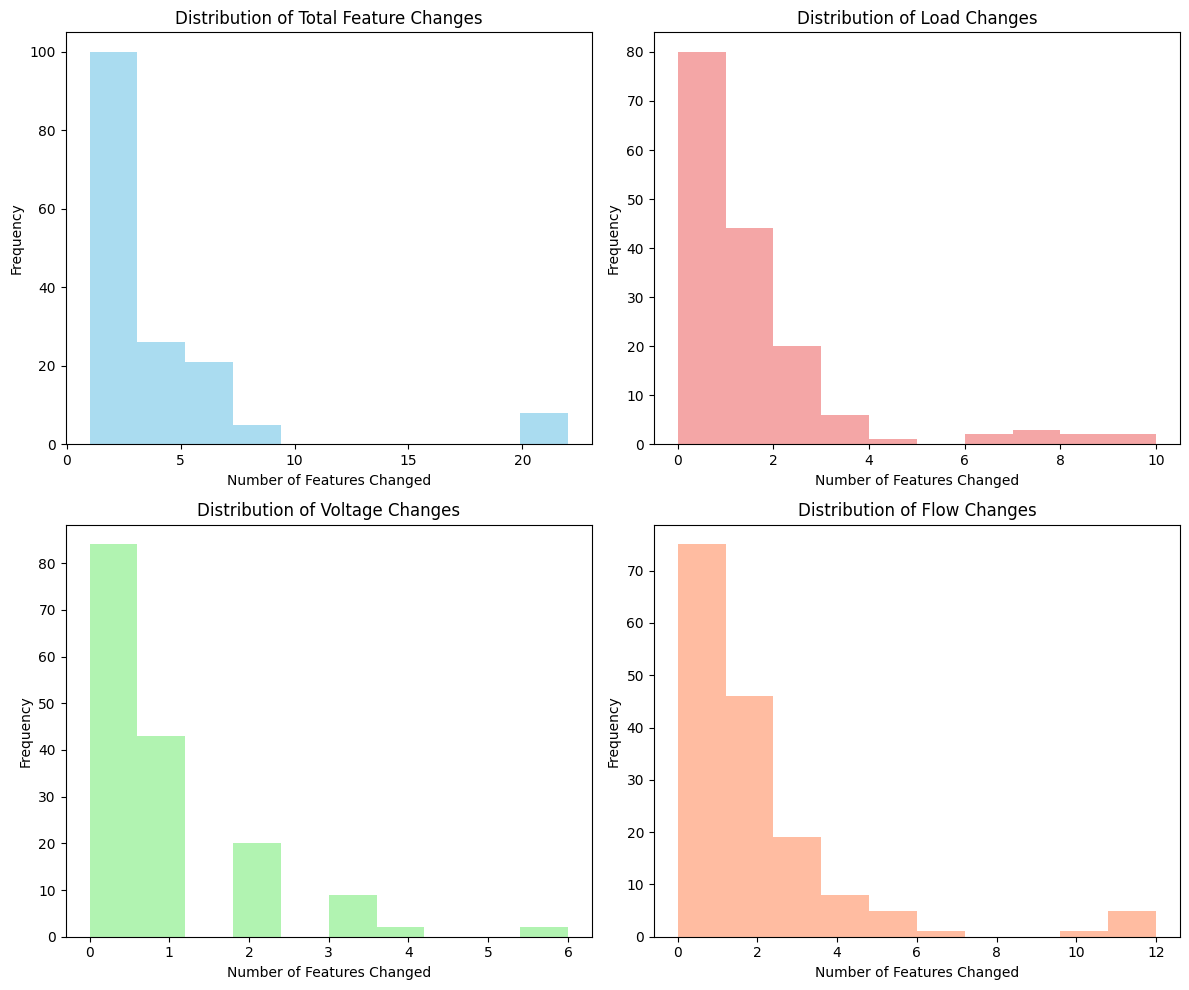

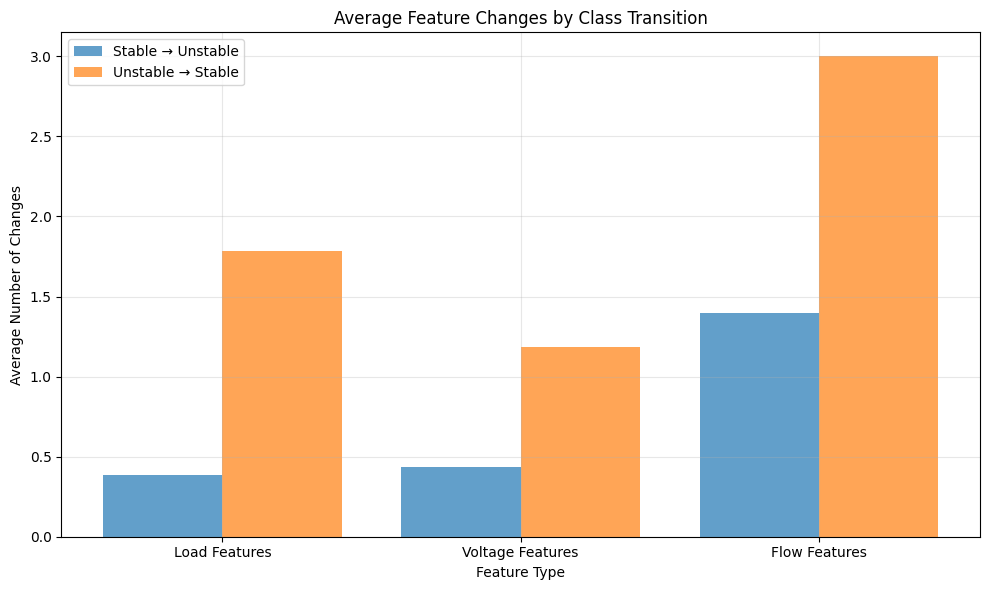

✅ Visualizations saved as PNG files

🎯 Phase 3.2 Complete: Counterfactual explanations generated successfully!
📁 Outputs:
   - counterfactual_analysis.xlsx: Detailed counterfactual results
   - counterfactual_feature_changes.png: Feature change distributions
   - counterfactual_class_transitions.png: Changes by class transition


In [8]:
# Visualize counterfactual changes
if all_counterfactuals:
    print("📊 Creating visualizations...")
    
    # Plot 1: Distribution of feature changes
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Total changes distribution
    axes[0,0].hist(analysis_df['total_changes'], bins=10, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Distribution of Total Feature Changes')
    axes[0,0].set_xlabel('Number of Features Changed')
    axes[0,0].set_ylabel('Frequency')
    
    # Changes by feature type
    feature_types = ['load_changes', 'voltage_changes', 'flow_changes']
    colors = ['lightcoral', 'lightgreen', 'lightsalmon']
    
    for i, (feat_type, color) in enumerate(zip(feature_types, colors)):
        if i < 3:
            row = (i + 1) // 2
            col = (i + 1) % 2
            axes[row, col].hist(analysis_df[feat_type], bins=10, alpha=0.7, color=color)
            axes[row, col].set_title(f'Distribution of {feat_type.replace("_", " ").title()}')
            axes[row, col].set_xlabel('Number of Features Changed')
            axes[row, col].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('counterfactual_feature_changes.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot 2: Changes by class transition
    plt.figure(figsize=(10, 6))
    
    stable_to_unstable = analysis_df[analysis_df['original_class'] == 0]
    unstable_to_stable = analysis_df[analysis_df['original_class'] == 1]
    
    x_pos = np.arange(3)
    feature_types_clean = ['Load Features', 'Voltage Features', 'Flow Features']
    
    if len(stable_to_unstable) > 0:
        stable_means = [stable_to_unstable['load_changes'].mean(), 
                      stable_to_unstable['voltage_changes'].mean(),
                      stable_to_unstable['flow_changes'].mean()]
        plt.bar(x_pos - 0.2, stable_means, 0.4, label='Stable → Unstable', alpha=0.7)
    
    if len(unstable_to_stable) > 0:
        unstable_means = [unstable_to_stable['load_changes'].mean(), 
                         unstable_to_stable['voltage_changes'].mean(),
                         unstable_to_stable['flow_changes'].mean()]
        plt.bar(x_pos + 0.2, unstable_means, 0.4, label='Unstable → Stable', alpha=0.7)
    
    plt.xlabel('Feature Type')
    plt.ylabel('Average Number of Changes')
    plt.title('Average Feature Changes by Class Transition')
    plt.xticks(x_pos, feature_types_clean)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('counterfactual_class_transitions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Visualizations saved as PNG files")

print("\n🎯 Phase 3.2 Complete: Counterfactual explanations generated successfully!")
print("📁 Outputs:")
print("   - counterfactual_analysis.xlsx: Detailed counterfactual results")
print("   - counterfactual_feature_changes.png: Feature change distributions")
print("   - counterfactual_class_transitions.png: Changes by class transition")